In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt


In [2]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["strategy"]).cumprod()
    n = len(df)/252
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["strategy"].std() * np.sqrt(252)
    return vol

def sharpe(DF,rf=0.055):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["strategy"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [3]:
ticker = 'KOTAKBANK.NS'
ohlcv_data = yf.download(ticker,period='9mo',interval='1d')
ohlcv_data.dropna(how="any",inplace=True)

df = copy.deepcopy(ohlcv_data)

df['daily_ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

[*********************100%***********************]  1 of 1 completed


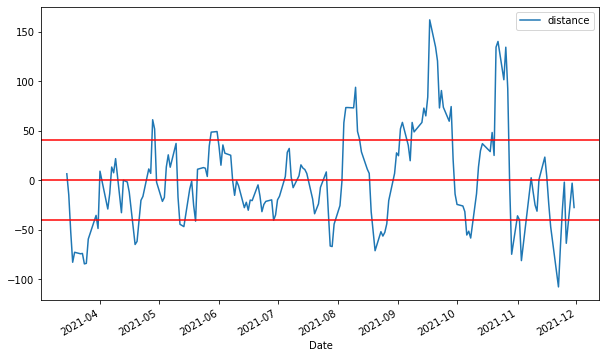

In [4]:

SMA = 10
df['SMA'] = df['Adj Close'].rolling(SMA).mean()

threshold = df['Adj Close'].rolling(SMA).std()[-1]
df['distance'] = df['Adj Close'] - df['SMA']

df['distance'].dropna().plot(figsize=(10, 6), legend=True)
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');


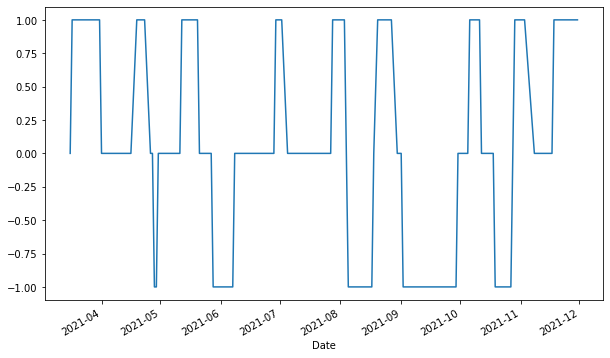

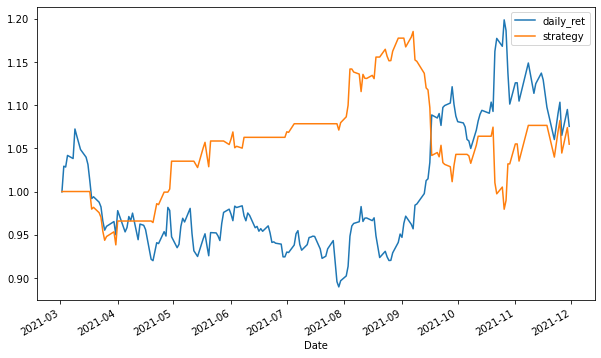

In [5]:
df['position'] = np.where(df['distance'] > threshold, -1, np.nan)
df['position'] = np.where(df['distance'] < -threshold, 1, df['position'])
df['position'] = np.where(df['distance'] * df['distance'].shift(1) < 0, 0, df['position'])

df['position'] = df['position'].ffill().fillna(0)

df['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1], figsize=(10, 6));


df['strategy'] = df['position'].shift(1) * df['daily_ret']
df[['daily_ret', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));


In [6]:
KPI_df = pd.DataFrame([CAGR(df), sharpe(df), max_dd(df)],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T


,Return,Sharpe Ratio,Max Drawdown
0,0.054641,-0.001794,0.178204
